**Project Idea**: Predictive Analytics for Customer Lifetime Value (CLV)

- **Description**: Develop a model to predict the lifetime value of a customer based on their purchasing history, browsing behavior, and other relevant factors. This can help the e-commerce company tailor marketing strategies and personalize customer experience.
- **Skills Demonstrated**: Predictive modeling, customer segmentation, machine learning.
- **dfset**: You can use the "Online Retail II" dfset from the UCI Machine Learning Repository. It contains all the transactions occurring for a UK-based and registered non-store online retail between 01/12/2009 and 09/12/2011. [UCI Machine Learning Repository: Online Retail II df Set](https://archive.ics.uci.edu/ml/dfsets/Online+Retail+II)


(Analyzing the first 10k rows due to hardware complexity)

#### Dataset Information

This Online Retail II df set contains all the transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011.The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers.

#### Variable Name
- InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation. 
- StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product. 
- Description: Product (item) name. Nominal. 
- Quantity: The quantities of each product (item) per transaction. Numeric.	
- InvoiceDate: Invice date and time. Numeric. The day and time when a transaction was generated. 
- UnitPrice: Unit price. Numeric. Product price per unit in sterling (Â£). 
- CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer. 
- Country: Country name. Nominal. The name of the country where a customer resides.

## Importing Libraries

In [191]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from sklearn.preprocessing import MinMaxScaler

1. `BetaGeoFitter`: This class is used for modeling customer transactions in a probabilistic way. It is based on the Beta-Geometric (BG) model, which is suitable for scenarios where customers have a probability of dropping out after each transaction.
<br>
2. `GammaGammaFitter`: This class is used for modeling the monetary value of transactions. It assumes that the monetary value follows a gamma distribution. This is useful when you want to predict the future value of customers based on their historical purchasing behavior.
<br>
3. `plot_period_transactions`: This function is used for visualizing the number of transactions over time. It helps you understand the distribution of transactions and identify any patterns or trends.

## Importing Data

In [192]:
# Read dfset
df_ = pd.read_excel("data.xlsx")
df = df_.copy()

In [193]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [194]:
df.shape

(100000, 8)

In [195]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      100000 non-null  object        
 1   StockCode    100000 non-null  object        
 2   Description  99701 non-null   object        
 3   Quantity     100000 non-null  int64         
 4   InvoiceDate  100000 non-null  datetime64[ns]
 5   Price        100000 non-null  float64       
 6   Customer ID  65085 non-null   float64       
 7   Country      100000 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 6.1+ MB


In [196]:
df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,100000.00000,100000,100000.000000,65085.000000
mean,8.89292,2011-01-07 05:17:41.038200064,5.396608,15351.001583
min,-74215.00000,2010-12-01 08:26:00,0.000000,12346.000000
25%,1.00000,2010-12-10 15:17:00,1.250000,13869.000000
50%,3.00000,2011-01-09 15:15:30,2.510000,15311.000000
75%,8.00000,2011-01-28 13:54:00,4.250000,16997.000000
max,74215.00000,2011-02-23 13:37:00,16888.020000,18283.000000
std,336.56270,NaN,120.891000,1769.756387


In [197]:
df.isnull().sum()

Invoice            0
StockCode          0
Description      299
Quantity           0
InvoiceDate        0
Price              0
Customer ID    34915
Country            0
dtype: int64

In [198]:
# Number of Customer in the dfset.
df["Customer ID"].nunique()

1664

In [199]:
# Number of Invoice in the dfset.
df["Invoice"].nunique()

4657

In [200]:
# Total number of products sold in the dfset
df["Quantity"].sum()

889292

In [201]:
# Total revenue in the dfset
(df["Quantity"] * df["Price"]).sum().astype(int)

1727708

In [202]:
# Total number of product in the dfset.
df["Description"].count()

99701

In [203]:
# dfset ordered from highest price to lowest price
df.sort_values(by = "Price", ascending  = False).head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
43702,C540117,AMAZONFEE,AMAZON FEE,-1,2011-01-05 09:55:00,16888.02,NaN,United Kingdom
43703,C540118,AMAZONFEE,AMAZON FEE,-1,2011-01-05 09:57:00,16453.71,NaN,United Kingdom
15016,C537630,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:04:00,13541.33,NaN,United Kingdom
16356,C537651,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:49:00,13541.33,NaN,United Kingdom
15017,537632,AMAZONFEE,AMAZON FEE,1,2010-12-07 15:08:00,13541.33,NaN,United Kingdom


In [204]:
# dfset ordered from lowest price to highest price
df.sort_values(by = "Price", ascending  = True).head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
23804,538249,85084,NaN,25,2010-12-10 12:19:00,0.0,NaN,United Kingdom
82794,543257,84611B,thrown away,-1430,2011-02-04 16:06:00,0.0,NaN,United Kingdom
82795,543258,84611B,NaN,1287,2011-02-04 16:06:00,0.0,NaN,United Kingdom
82796,543259,84612B,thrown away,-162,2011-02-04 16:07:00,0.0,NaN,United Kingdom
82797,543260,84613A,thrown away,-230,2011-02-04 16:07:00,0.0,NaN,United Kingdom


## Data Cleaning

In [205]:
# Changing the type of the 'InvoiceDate' column
df["InvoiceDate"] = df["InvoiceDate"].apply(pd.to_datetime)

In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      100000 non-null  object        
 1   StockCode    100000 non-null  object        
 2   Description  99701 non-null   object        
 3   Quantity     100000 non-null  int64         
 4   InvoiceDate  100000 non-null  datetime64[ns]
 5   Price        100000 non-null  float64       
 6   Customer ID  65085 non-null   float64       
 7   Country      100000 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 6.1+ MB


In [207]:
# Dropping the null values in the dfset. ("Customer ID is an important column cannot have null values")
df.dropna(inplace = True)

In [208]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 65085 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Invoice      65085 non-null  object        
 1   StockCode    65085 non-null  object        
 2   Description  65085 non-null  object        
 3   Quantity     65085 non-null  int64         
 4   InvoiceDate  65085 non-null  datetime64[ns]
 5   Price        65085 non-null  float64       
 6   Customer ID  65085 non-null  float64       
 7   Country      65085 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 4.5+ MB


In [209]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [210]:
df[df["Quantity"] < 0].head() # return invoices starting with "C"

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


In [211]:
# removing them
df = df[~df["Invoice"].str.contains("C", na = False)]

In [212]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63314 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Invoice      63314 non-null  object        
 1   StockCode    63314 non-null  object        
 2   Description  63314 non-null  object        
 3   Quantity     63314 non-null  int64         
 4   InvoiceDate  63314 non-null  datetime64[ns]
 5   Price        63314 non-null  float64       
 6   Customer ID  63314 non-null  float64       
 7   Country      63314 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 4.3+ MB


In [213]:
df[df["Quantity"] < 0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country


In [214]:
df[df["Price"] < 0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country


## Feature Engineering

In [215]:
# Calculating total price and adding it.
df["Total_Prize"] = df["Quantity"] * df["Price"]

In [216]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total_Prize
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


## RFM Analysis

RFM (Recency, Frequency, Monetary) and CLTV (Customer Lifetime Value) are both models used in the field of marketing and customer relationship management. They are often employed in machine learning and df analysis to understand and predict customer behavior.

1. **RFM Model:**
   - **Recency (R):** This refers to how recently a customer has made a purchase. Customers who have made a purchase more recently are often considered more valuable.
   - **Frequency (F):** This measures how often a customer makes a purchase. Customers who make frequent purchases may be more loyal and engaged.
   - **Monetary (M):** This represents the monetary value of a customer's purchases. High-value customers are typically more valuable to a business.

   The RFM model classifies customers based on these three dimensions, creating segments that help businesses tailor their marketing strategies. For example, a customer who made a high-value purchase recently might be targeted differently than a customer who hasn't made a purchase in a long time.

2. **CLTV Model:**
   - **Customer Lifetime Value (CLTV):** This model focuses on predicting the total value a customer is expected to bring to a business over their entire relationship. It takes into account not only the historical transactional df (similar to RFM) but also considers the potential future value of the customer.

   CLTV involves predicting how much revenue a customer is likely to generate over the course of their relationship with the business. This model is valuable for guiding marketing and customer acquisition strategies, as it helps businesses identify and prioritize high-value customers.

In summary, while RFM helps in segmenting customers based on their recent behavior, frequency of purchases, and monetary value, CLTV goes a step further by predicting the overall value a customer is likely to bring throughout their entire relationship with the business. Both models are useful for businesses looking to optimize their marketing efforts and enhance customer relationships.

In [217]:
df["InvoiceDate"].max() # most recent df

Timestamp('2011-02-23 13:37:00')

In [218]:
today_date = dt.datetime(2024,1,1)

In [219]:
# Assuming 'df' is your original dfframe
RFM = df.groupby("Customer ID").agg(
    Recency=('InvoiceDate', lambda x: (today_date - pd.to_datetime(x.max())).days),
    Frequency=('Invoice', 'nunique'),
    Monetary=('Total_Prize', 'sum')
).reset_index()

# Rename the columns if needed
RFM.columns = ['Customer ID', 'Recency', 'Frequency', 'Monetary']

In [220]:
RFM.set_index('Customer ID', inplace=True)

In [221]:
RFM.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,4730,1,77183.60
12347.0,4722,2,1187.18
12348.0,4723,2,1120.24
12350.0,4715,1,334.40
12352.0,4701,1,296.50


In [222]:
# The first five values with the highest monetary value
RFM.sort_values(by = "Monetary", ascending = False).head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,4730,1,77183.60
14646.0,4695,10,57866.02
18102.0,4710,6,38370.09
14156.0,4694,7,25752.25
15749.0,4737,2,22998.40


In [223]:
# The first five values with the lowest monetary value
RFM.sort_values(by = "Monetary", ascending = True).head()

,Recency,Frequency,Monetary
Customer ID,,,
16554.0,4736,1,0.85
16738.0,4702,1,3.75
16208.0,4694,1,5.10
16882.0,4722,1,9.90
15885.0,4714,1,15.00


**Recency_Score, Frequency_Score, Monetary_Score**<br>
I rate the recency, frequency, and monetary scores between 5 and 1. In this section, df with a score of 5 will be the df with the best recency score for us, df with a score of 1 will have the worst score.

**Recency_Score:**
You know, high recency values are bad for us. Because high recency values represent the day the customer stays away from the company. Customers with low recency values are customers who do not stay away from the company.

**Frequency_Score:**
High-frequency values are good for us. The Frequency value is that customer use how many use our company more.

**Monetary_Score:**
High-monetary values are good for us. The Monetary value is the customer how much pays the company.

In [224]:
# Define bin edges for Recency
recency_bins = [-np.inf, 5140, 5141, 5142, 5143, np.inf]
RFM["Recency_Score"] = pd.cut(RFM["Recency"], bins=recency_bins, labels=[5, 4, 3, 2, 1], include_lowest=True)

# Use qcut for Frequency and Monetary
RFM["Frequency_Score"] = pd.qcut(RFM["Frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
RFM["Monetary_Score"] = pd.qcut(RFM["Monetary"], 5, labels=[1, 2, 3, 4, 5])

In [225]:
RFM.head()

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score
Customer ID,,,,,,
12346.0,4730,1,77183.60,5,1,5
12347.0,4722,2,1187.18,5,4,5
12348.0,4723,2,1120.24,5,4,5
12350.0,4715,1,334.40,5,1,3
12352.0,4701,1,296.50,5,1,2


In [226]:
RFM["RF_Score"] = RFM["Recency_Score"].astype(str) + RFM["Frequency_Score"].astype(str)
RFM.head()

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RF_Score
Customer ID,,,,,,,
12346.0,4730,1,77183.60,5,1,5,51
12347.0,4722,2,1187.18,5,4,5,54
12348.0,4723,2,1120.24,5,4,5,54
12350.0,4715,1,334.40,5,1,3,51
12352.0,4701,1,296.50,5,1,2,51


In [227]:
seg_map = {
    r'[1-2][1-2]' : 'Hibernating',
    r'[1-2][3-4]' : 'Risky',
    r'[1-2]5' : 'Most Wanted',
    r'3[1-2]' : 'About_to_Go',
    r'33' : 'Needs_Attention',
    r'[3-4][4-5]' : 'Loyal',
    r'41' : 'Promising',
    r'51' : 'New_Customers',
    r'[4-5][2-3]' : 'Potential_to_be_Loyal',
    r'5[4-5]' : 'Champions'}

RFM["segment"] = RFM["RF_Score"].replace(seg_map, regex = True)

RFM.head()

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RF_Score,segment
Customer ID,,,,,,,,
12346.0,4730,1,77183.60,5,1,5,51,New_Customers
12347.0,4722,2,1187.18,5,4,5,54,Champions
12348.0,4723,2,1120.24,5,4,5,54,Champions
12350.0,4715,1,334.40,5,1,3,51,New_Customers
12352.0,4701,1,296.50,5,1,2,51,New_Customers


In [228]:
RFM[["segment", "Recency", "Frequency", "Monetary"]].groupby("segment").agg(["mean", "sum", "count"])

Recency                Frequency              \
                              mean      sum count      mean   sum count   
segment                                                                   
Champions              4718.821596  3015327   639  3.480438  2224   639   
New_Customers          4734.456250  1515026   320  1.000000   320   320   
Potential_to_be_Loyal  4741.385580  3025004   638  1.000000   638   638   

                          Monetary                    
                              mean         sum count  
segment                                               
Champions              1707.777277  1091269.68   639  
New_Customers           667.014969   213444.79   320  
Potential_to_be_Loyal   336.211740   214503.09   638

In [229]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total_Prize
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [230]:
quartile1 = df["Price"].quantile(0.01)
quartile3 = df["Price"].quantile(0.99)
interquantile_range = quartile3 - quartile1
up_limit = quartile3 + 1.5 * interquantile_range
low_limit = quartile1 - 1.5 * interquantile_range
df.loc[(df["Price"] > up_limit), "Price"] = up_limit

In [231]:
quartile1 = df["Quantity"].quantile(0.01)
quartile3 = df["Quantity"].quantile(0.99)
interquantile_range = quartile3 - quartile1
up_limit = quartile3 + 1.5 * interquantile_range
low_limit = quartile1 - 1.5 * interquantile_range
df.loc[(df["Quantity"] > up_limit), "Quantity"] = up_limit

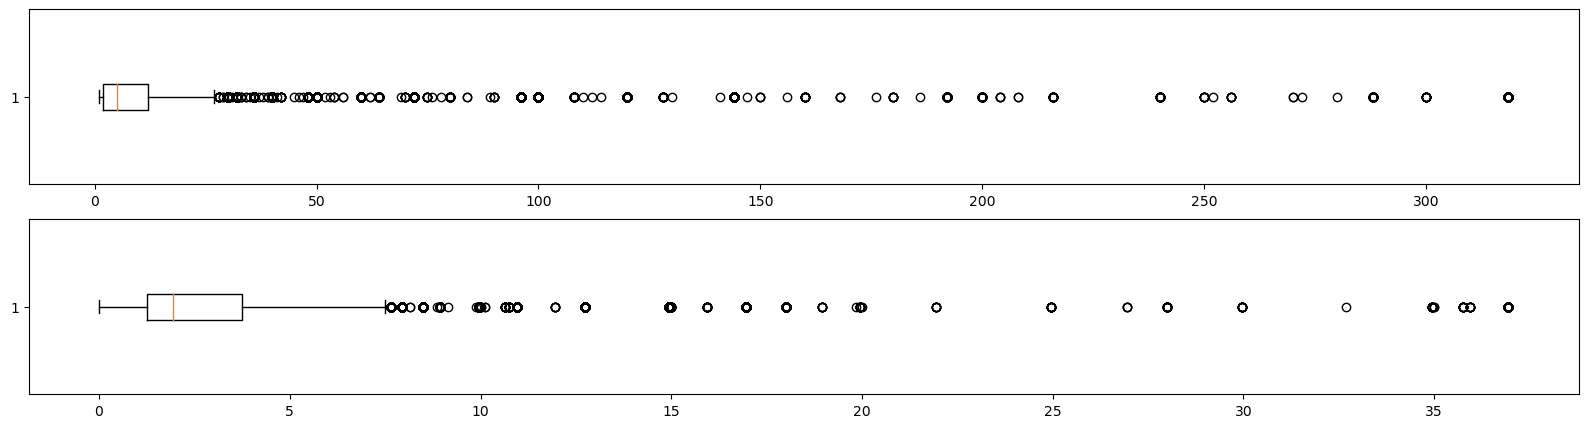

In [232]:
col_list = ["Quantity", "Price"]

f, ax = plt.subplots(2,1, figsize = (20,5))
for i in range(0,2):
    ax[i].boxplot(df[col_list[i]], vert = 0)
plt.show()

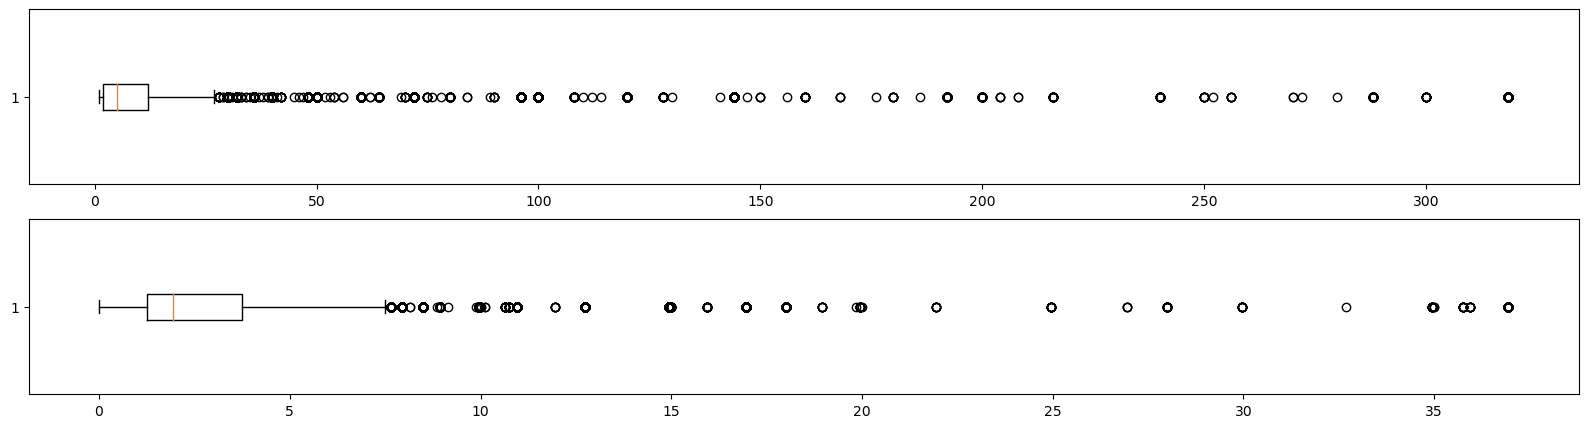

In [233]:
# I observe them before removing outliers.
f, ax = plt.subplots(2,1, figsize = (20,5))
col_list = ["Quantity", "Price"]
for i in range(0,2):
    ax[i].boxplot(df[col_list[i]], vert = 0)
plt.show()

The RFM analysis has been conducted, resulting in the following metrics for each customer:

- **Recency**: The number of days since the customer's last purchase.
- **Frequency**: The number of unique transactions (invoices) per customer.
- **Monetary**: The total amount spent by the customer.

For example, the first customer (ID 12395.0) has a recency of 4,776 days, indicating their last purchase was that long ago. They have only 1 recorded transaction (frequency) with a total spend (monetary value) of £346.10.

These RFM metrics are crucial for customer segmentation and understanding customer behavior. They form the foundation for further analysis, such as segmenting customers into groups like 'Champions', 'Loyal', 'At Risk', etc., based on these metrics.

## CLTV Analysis

In [235]:
today_date = dt.datetime(2011, 12, 11)

# Create the CLTV dfframe.
CLTV = df.groupby("Customer ID").agg({"InvoiceDate" : [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days, # recency
                                                  lambda InvoiceDate: (today_date - InvoiceDate.min()).days], # T
                                         "Invoice" : lambda Invoice: Invoice.nunique(), # frequnecy
                                         "Total_Prize": lambda Total_Prize: Total_Prize.sum()}) # monatery

In [236]:
# Assuming 'df' is your original dfframe
CLTV = df.groupby("Customer ID").agg(
    Recency=('InvoiceDate', lambda x: (today_date - pd.to_datetime(x.max())).days),
    T=('InvoiceDate', lambda x: (today_date - pd.to_datetime(x.min())).days),
    Frequency=('Invoice', 'nunique'),
    Monetary=('Total_Prize', 'sum')
).reset_index()

# Rename the columns if needed
CLTV.columns = ['Customer ID', 'Recency', "T", 'Frequency', 'Monetary']

In [237]:
CLTV.head()

,Customer ID,Recency,T,Frequency,Monetary
0,12346.0,326,326,1,77183.60
1,12347.0,318,368,2,1187.18
2,12348.0,319,359,2,1120.24
3,12350.0,311,311,1,334.40
4,12352.0,297,297,1,296.50


In [238]:
# Average earnings per purchase
CLTV["Monetary"] = CLTV["Monetary"] / CLTV["Frequency"]

In [239]:
CLTV.head()

,Customer ID,Recency,T,Frequency,Monetary
0,12346.0,326,326,1,77183.60
1,12347.0,318,368,2,593.59
2,12348.0,319,359,2,560.12
3,12350.0,311,311,1,334.40
4,12352.0,297,297,1,296.50


In [240]:
CLTV = CLTV[CLTV["Frequency"] > 1]

In [241]:
CLTV.head()

,Customer ID,Recency,T,Frequency,Monetary
1,12347.0,318,368,2,593.590
2,12348.0,319,359,2,560.120
6,12359.0,306,332,2,1193.205
8,12365.0,292,292,2,320.690
9,12370.0,358,361,2,934.010


In [242]:
# turn the recency and T values to the weekly format 
CLTV["Recency"] = CLTV["Recency"] / 7
CLTV["T"] = CLTV["T"] / 7

In [243]:
CLTV.head()

,Customer ID,Recency,T,Frequency,Monetary
1,12347.0,45.428571,52.571429,2,593.590
2,12348.0,45.571429,51.285714,2,560.120
6,12359.0,43.714286,47.428571,2,1193.205
8,12365.0,41.714286,41.714286,2,320.690
9,12370.0,51.142857,51.571429,2,934.010


## EDA

In [244]:
# Inspecting the first few rows of the dfsets
print("RFM dfFrame:")
RFM.head()

RFM dfFrame:


,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RF_Score,segment
Customer ID,,,,,,,,
12346.0,4730,1,77183.60,5,1,5,51,New_Customers
12347.0,4722,2,1187.18,5,4,5,54,Champions
12348.0,4723,2,1120.24,5,4,5,54,Champions
12350.0,4715,1,334.40,5,1,3,51,New_Customers
12352.0,4701,1,296.50,5,1,2,51,New_Customers


In [245]:
print("\nCLTV dfFrame:")
CLTV.head()


CLTV dfFrame:


,Customer ID,Recency,T,Frequency,Monetary
1,12347.0,45.428571,52.571429,2,593.590
2,12348.0,45.571429,51.285714,2,560.120
6,12359.0,43.714286,47.428571,2,1193.205
8,12365.0,41.714286,41.714286,2,320.690
9,12370.0,51.142857,51.571429,2,934.010


In [246]:
# Converting the score columns to integer type
RFMv2 = RFM.copy()
RFMv2["Recency_Score"] = RFMv2["Recency_Score"].astype(int)
RFMv2["Frequency_Score"] = RFMv2["Frequency_Score"].astype(int)
RFMv2["Monetary_Score"] = RFMv2["Monetary_Score"].astype(int)

In [247]:
rfScore = "55"
# Sorting and displaying based on Recency
print(f"Top five Recency - RF Score {rfScore}")
RFM[RFM["RF_Score"] == rfScore].sort_values(by="Recency", ascending=True).head()

Top five Recency - RF Score 55


,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RF_Score,segment
Customer ID,,,,,,,,
15373.0,4694,4,900.00,5,5,4,55,Champions
18041.0,4694,7,1557.58,5,5,5,55,Champions
13089.0,4694,24,15557.62,5,5,5,55,Champions
14156.0,4694,7,25752.25,5,5,5,55,Champions
14978.0,4694,3,1142.45,5,5,5,55,Champions


In [248]:
print(f"\nBottom five Recency - RF Score {rfScore}")
RFM[RFM["RF_Score"] == rfScore].sort_values(by="Recency", ascending=False).head()


Bottom five Recency - RF Score 55


,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RF_Score,segment
Customer ID,,,,,,,,
17850.0,4777,34,5391.21,5,5,5,55,Champions
15299.0,4777,3,1835.01,5,5,5,55,Champions
15502.0,4773,3,929.40,5,5,4,55,Champions
17191.0,4773,3,510.11,5,5,3,55,Champions
15332.0,4771,4,1661.06,5,5,5,55,Champions


In [249]:
# Sorting and displaying based on Frequency
print(f"\nTop five Frequency - RF Score {rfScore}")
RFM[RFM["RF_Score"] == rfScore].sort_values(by="Frequency", ascending=False).head()


Top five Frequency - RF Score 55


,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RF_Score,segment
Customer ID,,,,,,,,
12748.0,4695,41,4678.65,5,5,5,55,Champions
17850.0,4777,34,5391.21,5,5,5,55,Champions
15311.0,4694,26,12877.85,5,5,5,55,Champions
14606.0,4697,24,3674.44,5,5,5,55,Champions
13089.0,4694,24,15557.62,5,5,5,55,Champions


In [250]:
print(f"\nBottom five Frequency - RF Score {rfScore}")
RFM[RFM["RF_Score"] == rfScore].sort_values(by="Frequency", ascending=True).head()


Bottom five Frequency - RF Score 55


,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RF_Score,segment
Customer ID,,,,,,,,
15574.0,4763,3,590.15,5,5,4,55,Champions
15854.0,4716,3,747.30,5,5,4,55,Champions
15916.0,4735,3,575.06,5,5,4,55,Champions
15939.0,4716,3,1116.30,5,5,5,55,Champions
15983.0,4765,3,1148.27,5,5,5,55,Champions


In [251]:
# Sorting and displaying based on Monetary
print(f"\nTop five Monetary - RF Score {rfScore}")
RFM[RFM["RF_Score"] == rfScore].sort_values(by="Monetary", ascending=False).head()


Top five Monetary - RF Score 55


,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RF_Score,segment
Customer ID,,,,,,,,
14646.0,4695,10,57866.02,5,5,5,55,Champions
18102.0,4710,6,38370.09,5,5,5,55,Champions
14156.0,4694,7,25752.25,5,5,5,55,Champions
15061.0,4706,18,22671.33,5,5,5,55,Champions
17450.0,4737,5,20649.04,5,5,5,55,Champions


In [252]:
print(f"\nBottom five Monetary - RF Score {rfScore}")
RFM[RFM["RF_Score"] == rfScore].sort_values(by="Monetary", ascending=True).head()


Bottom five Monetary - RF Score 55


,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RF_Score,segment
Customer ID,,,,,,,,
17460.0,4723,3,203.80,5,5,2,55,Champions
17848.0,4715,3,213.91,5,5,2,55,Champions
16321.0,4710,3,223.65,5,5,2,55,Champions
17288.0,4700,3,290.52,5,5,2,55,Champions
17912.0,4715,5,311.01,5,5,2,55,Champions


In [253]:
# Recency
print("Top five Recency")
RFM.sort_values(by="Recency", ascending=True).head()

Top five Recency


,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RF_Score,segment
Customer ID,,,,,,,,
13694.0,4694,10,10770.16,5,5,5,55,Champions
13089.0,4694,24,15557.62,5,5,5,55,Champions
15311.0,4694,26,12877.85,5,5,5,55,Champions
13804.0,4694,1,723.63,5,1,4,51,New_Customers
12980.0,4694,4,2834.94,5,5,5,55,Champions


In [254]:
print("\nBottom five Recency")
RFM.sort_values(by="Recency", ascending=False).head()


Bottom five Recency


,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RF_Score,segment
Customer ID,,,,,,,,
16218.0,4778,1,471.30,5,3,3,53,Potential_to_be_Loyal
16274.0,4778,1,357.95,5,3,3,53,Potential_to_be_Loyal
17572.0,4778,1,70.80,5,3,1,53,Potential_to_be_Loyal
17420.0,4778,1,130.85,5,3,1,53,Potential_to_be_Loyal
16552.0,4778,1,95.29,5,3,1,53,Potential_to_be_Loyal


In [255]:
# Frequency
print("\nTop five Frequency")
RFM.sort_values(by="Frequency", ascending=False).head()


Top five Frequency


,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RF_Score,segment
Customer ID,,,,,,,,
12748.0,4695,41,4678.65,5,5,5,55,Champions
17850.0,4777,34,5391.21,5,5,5,55,Champions
15311.0,4694,26,12877.85,5,5,5,55,Champions
14606.0,4697,24,3674.44,5,5,5,55,Champions
13089.0,4694,24,15557.62,5,5,5,55,Champions


In [256]:
print("\nBottom five Frequency")
RFM.sort_values(by="Frequency", ascending=True).head()


Bottom five Frequency


,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RF_Score,segment
Customer ID,,,,,,,,
12346.0,4730,1,77183.60,5,1,5,51,New_Customers
15799.0,4739,1,320.22,5,2,3,52,Potential_to_be_Loyal
15796.0,4707,1,343.92,5,2,3,52,Potential_to_be_Loyal
15789.0,4763,1,351.30,5,2,3,52,Potential_to_be_Loyal
15785.0,4700,1,928.58,5,2,4,52,Potential_to_be_Loyal


In [257]:
# Monetary
print("\nTop five Monetary")
RFM.sort_values(by="Monetary", ascending=False).head()


Top five Monetary


,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RF_Score,segment
Customer ID,,,,,,,,
12346.0,4730,1,77183.60,5,1,5,51,New_Customers
14646.0,4695,10,57866.02,5,5,5,55,Champions
18102.0,4710,6,38370.09,5,5,5,55,Champions
14156.0,4694,7,25752.25,5,5,5,55,Champions
15749.0,4737,2,22998.40,5,4,5,54,Champions


In [258]:
print("\nBottom five Monetary")
RFM.sort_values(by="Monetary", ascending=True).head()


Bottom five Monetary


,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RF_Score,segment
Customer ID,,,,,,,,
16554.0,4736,1,0.85,5,3,1,53,Potential_to_be_Loyal
16738.0,4702,1,3.75,5,3,1,53,Potential_to_be_Loyal
16208.0,4694,1,5.10,5,3,1,53,Potential_to_be_Loyal
16882.0,4722,1,9.90,5,3,1,53,Potential_to_be_Loyal
15885.0,4714,1,15.00,5,2,1,52,Potential_to_be_Loyal


In [259]:
RFM["segment"].value_counts()

segment
Champions                639
Potential_to_be_Loyal    638
New_Customers            320
Name: count, dtype: int64

In [260]:
segments = ["Champions"]
for segment in segments:
    print(segment, ": ")
    print("Top five")
    print(RFM[RFM["segment"] == segment].sort_values(by="segment", ascending=False).head())
    
    print("Bottom five")
    print(RFM[RFM["segment"] == segment].sort_values(by="segment", ascending=True).head())

    print("Quantiles")
    print(RFM[RFM["segment"] == segment][["segment", "Recency", "Frequency", "Monetary"]].groupby("segment").agg(["count", "mean", "sum"]))


Champions : 
Top five
             Recency  Frequency  Monetary Recency_Score Frequency_Score  \
Customer ID                                                               
12347.0         4722          2   1187.18             5               4   
16710.0         4765          2    524.97             5               4   
16656.0         4696          3   1398.32             5               5   
16670.0         4731          3    778.51             5               5   
16684.0         4701          6   9811.98             5               5   

            Monetary_Score RF_Score    segment  
Customer ID                                     
12347.0                  5       54  Champions  
16710.0                  4       54  Champions  
16656.0                  5       55  Champions  
16670.0                  4       55  Champions  
16684.0                  5       55  Champions  
Bottom five
             Recency  Frequency  Monetary Recency_Score Frequency_Score  \
Customer ID           

/Users/sudhishsubramaniam/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



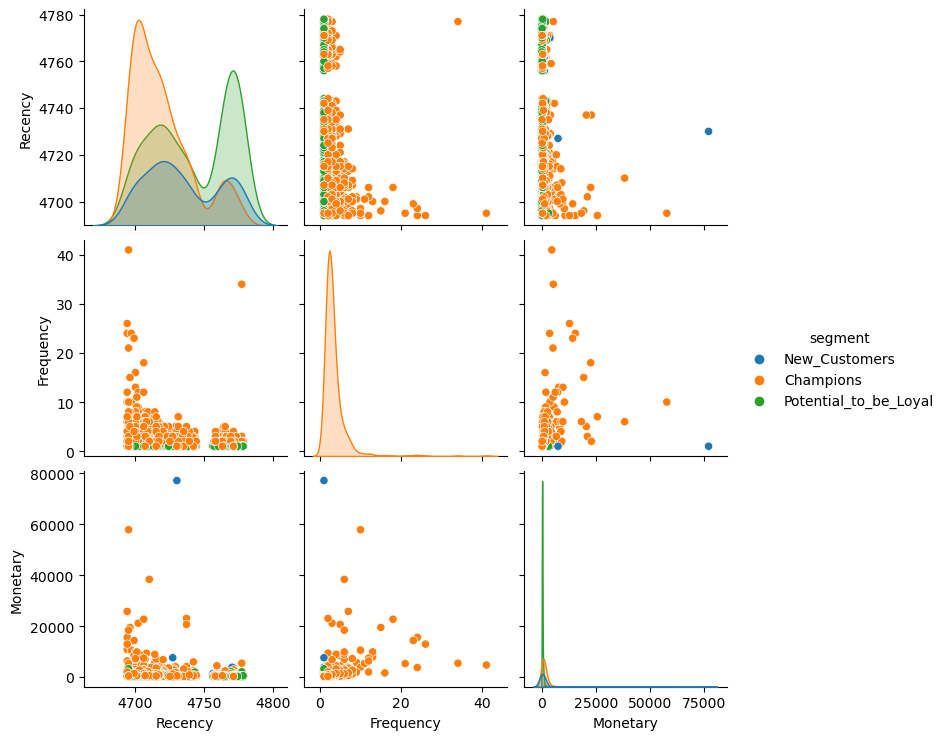

In [263]:
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
import seaborn as sns

init_notebook_mode(connected=True)

# Now you can create your plots
fig = px.scatter(RFMv2, x="Recency_Score", y="Frequency_Score", color="segment", size='Monetary_Score', hover_data=['Monetary_Score'])
iplot(fig)

sns.pairplot(RFM, hue="segment")

The exploratory data analysis (EDA) provides the following insights:

1. **Descriptive Statistics**:
   - The dataset contains 7,609 entries after preprocessing.
   - Quantity: Ranges from 1 to 2880 with an average of around 11 per transaction.
   - Price: Varies from 0 to £295, with an average price of approximately £3.10.

2. **Unique Counts**:
   - There are 303 unique customers.
   - The dataset contains 401 unique invoices.

3. **Total Figures**:
   - Total products sold: 82,870 items.
   - Total revenue generated: £148,206.83.

4. **Top Products by Quantity Sold**:
   - The top-selling product is 'WORLD WAR 2 GLIDERS ASSTD DESIGNS' with 3,408 units sold.
   - Other top products include assorted color T-light holders, red harmonicas, assorted incense packs, and white hanging heart T-light holders.

5. **Distribution Plots**:
   - The 'Quantity' distribution is heavily right-skewed, indicating that most purchases involve smaller quantities, with a few large quantity purchases.
   - The 'Price' distribution is also right-skewed, showing that lower-priced items are more commonly sold, with a few high-priced items.

## Modelling

In [264]:
bgf = BetaGeoFitter(penalizer_coef = 0.001)
bgf.fit(CLTV["Frequency"],
       CLTV["Recency"],
       CLTV["T"])

<lifetimes.BetaGeoFitter: fitted with 627 subjects, a: 0.00, alpha: 60.93, b: 0.00, r: 4.19>

In [265]:
# Adding the three monthly values to the CLTV
CLTV["expected_purc_3_month"] = bgf.predict(4*3, CLTV["Frequency"], CLTV["Recency"], CLTV["T"])

In [266]:
CLTV["expected_purc_6_month"] = bgf.predict(4*6, CLTV["Frequency"], CLTV["Recency"], CLTV["T"]).sort_values(ascending = False).head(10)

In [267]:
CLTV.head()

,Customer ID,Recency,T,Frequency,Monetary,expected_purc_3_month,expected_purc_6_month
1,12347.0,45.428571,52.571429,2,593.590,0.653990,NaN
2,12348.0,45.571429,51.285714,2,560.120,0.661482,NaN
6,12359.0,43.714286,47.428571,2,1193.205,0.685028,NaN
8,12365.0,41.714286,41.714286,2,320.690,0.723163,NaN
9,12370.0,51.142857,51.571429,2,934.010,0.659803,NaN


In [268]:
ggf = GammaGammaFitter(penalizer_coef = 0.01)
ggf.fit(CLTV["Frequency"], CLTV["Monetary"])

<lifetimes.GammaGammaFitter: fitted with 627 subjects, p: 3.77, q: 0.33, v: 3.69>

In [269]:
ggf.conditional_expected_average_profit(CLTV["Frequency"], CLTV["Monetary"]).sort_values(ascending = False).head(10)

912     12619.154872
23       7481.809651
1552     6590.271825
629      5891.370984
129      5118.258943
1366     4282.318439
488      3774.985505
1379     3153.221109
176      2914.743178
1353     2400.726067
dtype: float64

In [270]:
CLTV["cltv"] = ggf.customer_lifetime_value(bgf,
                                  CLTV["Frequency"], CLTV["Recency"], CLTV["T"], CLTV["Monetary"],
                                  time = 6, freq = "W", discount_rate = 0.01)

In [271]:
CLTV.head()

,Customer ID,Recency,T,Frequency,Monetary,expected_purc_3_month,expected_purc_6_month,cltv
1,12347.0,45.428571,52.571429,2,593.590,0.653990,NaN,896.593521
2,12348.0,45.571429,51.285714,2,560.120,0.661482,NaN,855.890079
6,12359.0,43.714286,47.428571,2,1193.205,0.685028,NaN,1884.885084
8,12365.0,41.714286,41.714286,2,320.690,0.723163,NaN,537.035593
9,12370.0,51.142857,51.571429,2,934.010,0.659803,NaN,1421.716700


In [272]:
CLTV["segment"] = pd.qcut(CLTV["cltv"], 4, labels = ["D", "C", "B", "A"])

In [273]:
CLTV.head()

,Customer ID,Recency,T,Frequency,Monetary,expected_purc_3_month,expected_purc_6_month,cltv,segment
1,12347.0,45.428571,52.571429,2,593.590,0.653990,NaN,896.593521,A
2,12348.0,45.571429,51.285714,2,560.120,0.661482,NaN,855.890079,A
6,12359.0,43.714286,47.428571,2,1193.205,0.685028,NaN,1884.885084,A
8,12365.0,41.714286,41.714286,2,320.690,0.723163,NaN,537.035593,B
9,12370.0,51.142857,51.571429,2,934.010,0.659803,NaN,1421.716700,A


### Model Fit and Predictions:
1. **BetaGeoFitter Results**:
   - This model was fitted with 627 subjects, indicating a substantial customer base for analysis.
   - The parameters (`a`, `alpha`, `b`, `r`) show the model's fit to the frequency and recency of purchases.
   - Predictions like `expected_purc_3_month` and `expected_purc_6_month` estimate future customer transactions over 3 and 6 months, respectively. For example, Customer ID 12347.0 is expected to make approximately 0.65 purchases in the next 3 months.

2. **GammaGammaFitter Results**:
   - The fitted parameters (`p`, `q`, `v`) indicate the model's understanding of the monetary value aspect of customer transactions.
   - The conditional expected average profit for customers (e.g., Customer ID 912 with £12,619.15) shows the predicted average revenue from each customer, which is crucial for understanding customer value.

## Results

In [274]:
CLTV.sort_values(by = "Recency", ascending = False).head()

,Customer ID,Recency,T,Frequency,Monetary,expected_purc_3_month,expected_purc_6_month,cltv,segment
998,16048.0,53.428571,53.428571,2,128.220,0.649088,NaN,194.380874,D
1244,17025.0,53.428571,53.428571,2,80.485,0.649088,NaN,123.041203,D
1391,17552.0,53.285714,53.285714,2,149.260,0.649900,NaN,226.107474,D
800,15299.0,53.285714,53.285714,3,611.670,0.754961,NaN,1031.939175,A
788,15260.0,53.285714,53.285714,2,210.250,0.649900,NaN,317.370667,D


In [275]:
CLTV.sort_values(by = "Recency", ascending = True).head()

,Customer ID,Recency,T,Frequency,Monetary,expected_purc_3_month,expected_purc_6_month,cltv,segment
1437,17706.0,41.428571,52.428571,4,222.212500,0.866525,NaN,424.546741,C
488,14156.0,41.428571,53.142857,7,3678.892857,1.176678,NaN,9321.171353,A
447,13993.0,41.428571,47.285714,2,411.425000,0.685932,NaN,652.687626,B
823,15373.0,41.428571,53.142857,4,225.000000,0.861099,NaN,427.158870,C
1360,17428.0,41.428571,52.714286,6,518.353333,1.075526,NaN,1206.921899,A


In [276]:
CLTV.sort_values(by = "T", ascending = False).head()

,Customer ID,Recency,T,Frequency,Monetary,expected_purc_3_month,expected_purc_6_month,cltv,segment
226,13093.0,44.428571,53.428571,6,1176.741667,1.068808,NaN,2720.980124,A
1036,16210.0,44.285714,53.428571,6,1479.490000,1.068808,NaN,3420.659582,A
1244,17025.0,53.428571,53.428571,2,80.485000,0.649088,NaN,123.041203,D
1495,17897.0,52.571429,53.428571,2,217.310000,0.649088,NaN,327.525346,D
74,12583.0,43.285714,53.428571,3,635.860000,0.754018,NaN,1071.327930,A


In [277]:
CLTV.sort_values(by = "T", ascending = True).head()

,Customer ID,Recency,T,Frequency,Monetary,expected_purc_3_month,expected_purc_6_month,cltv,segment
1572,18172.0,41.428571,41.428571,2,989.190,0.725181,NaN,1654.725777,A
8,12365.0,41.714286,41.714286,2,320.690,0.723163,NaN,537.035593,B
1592,18257.0,41.571429,42.428571,2,181.900,0.718165,NaN,303.829400,D
35,12455.0,42.285714,42.428571,2,849.450,0.718165,NaN,1407.650877,A
707,14944.0,42.428571,42.428571,2,377.145,0.718165,NaN,626.675066,B


In [278]:
CLTV.sort_values(by = "Frequency", ascending = False).head()

,Customer ID,Recency,T,Frequency,Monetary,expected_purc_3_month,expected_purc_6_month,cltv,segment
128,12748.0,41.571429,53.428571,41,114.113415,4.741358,9.482717,1141.197071,A
1475,17850.0,53.285714,53.428571,34,158.565000,4.006848,8.013697,1341.141113,A
804,15311.0,41.428571,53.428571,26,495.301923,3.167408,6.334816,3315.631755,A
223,13089.0,41.428571,52.857143,24,648.234167,2.972400,5.944801,4074.351152,A
618,14606.0,41.857143,53.428571,24,153.101667,2.957548,5.915096,958.216960,A


In [279]:
CLTV.sort_values(by = "Frequency", ascending = True).head()

,Customer ID,Recency,T,Frequency,Monetary,expected_purc_3_month,expected_purc_6_month,cltv,segment
1,12347.0,45.428571,52.571429,2,593.59,0.653990,NaN,896.593521,A
925,15797.0,43.571429,45.714286,2,755.10,0.696039,NaN,1213.077426,A
917,15759.0,42.428571,51.285714,2,92.52,0.661482,NaN,143.720400,D
913,15750.0,52.428571,52.428571,2,170.26,0.654814,NaN,259.478325,D
912,15749.0,47.571429,47.571429,2,11499.20,0.684126,NaN,18116.072206,A


In [280]:
CLTV.sort_values(by = "Monetary", ascending = False).head()

,Customer ID,Recency,T,Frequency,Monetary,expected_purc_3_month,expected_purc_6_month,cltv,segment
912,15749.0,47.571429,47.571429,2,11499.200000,0.684126,NaN,18116.072206,A
23,12415.0,42.571429,48.285714,3,7038.633333,0.789523,NaN,12395.641018,A
1552,18102.0,43.714286,52.571429,6,6395.015000,1.076879,NaN,14892.512834,A
629,14646.0,41.571429,50.714286,10,5786.602000,1.524716,NaN,18849.636155,A
129,12753.0,43.428571,51.857143,2,4662.915000,0.658131,NaN,7068.583628,A


In [281]:
CLTV.sort_values(by = "Monetary", ascending = True).head()

,Customer ID,Recency,T,Frequency,Monetary,expected_purc_3_month,expected_purc_6_month,cltv,segment
185,12970.0,46.142857,46.142857,2,11.900,0.693253,NaN,21.939011,D
1531,18037.0,46.142857,51.857143,2,19.775,0.658131,NaN,32.760630,D
836,15422.0,46.285714,46.285714,2,48.850,0.692330,NaN,80.810153,D
747,15107.0,44.571429,53.285714,6,53.250,1.070145,NaN,124.642454,D
1491,17888.0,45.428571,51.142857,2,61.065,0.662326,NaN,95.935561,D


### CLTV Calculations and Segmentations:
1. **Customer Lifetime Value**:
   - The `cltv` column represents the estimated lifetime value of each customer. Higher values indicate customers who are expected to bring more revenue in the future. For instance, Customer ID 12359.0 has a high CLTV of £1,884.89, suggesting a high-value customer.
   - The segmentation (A, B, C, D) based on CLTV scores allows for targeted marketing and customer relationship management. 'A' segment customers are the most valuable, while 'D' segment customers are the least.

### Sorting and Analysis:
- Sorting by different metrics like `Recency`, `Frequency`, `Monetary`, and `T` (customer's age in terms of their relationship with the company), you've effectively identified various types of customers:
  - **By Recency**: Customers with the highest and lowest recency values. For instance, Customer ID 16048.0 has one of the highest recency values, indicating a risk of churn.
  - **By Frequency**: Highlights the most and least frequent shoppers. Customer ID 12748.0, with 41 purchases, is a frequent buyer.
  - **By Monetary**: Shows customers who have spent the most and least. Customer ID 15749.0 has a high monetary value, indicating significant spending.

### Insights and Implications:
1. **Customer Segmentation**: This model helps in effectively segmenting customers, which is crucial for personalized marketing strategies and optimizing customer engagement efforts.
2. **Resource Allocation**: Understanding which customers bring more value allows for better allocation of marketing and retention resources.
3. **Personalized Strategies**: High CLTV customers can be targeted with loyalty programs, while efforts can be made to re-engage those with high recency but low frequency or monetary values.
4. **Revenue Predictions**: The model aids in forecasting future revenues and understanding the health of the customer base.

### Conclusion:
The CLTV model provides a robust framework for understanding customer behavior, predicting future transactions, and segmenting customers based on their value to the company. It's a powerful tool for strategic decision-making in marketing and customer relationship management.